<a href="https://colab.research.google.com/github/mazyaniv/Channel_estimation/blob/yaniv/Fake_news_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detection

##Introduction

The spread of fake news has become a major problem with its impact felt in journalism, commerce, and democracy. This has resulted in a loss of trust in media sources, leaving people uncertain. To combat this issue, researchers in the field of Artificial Intelligence have been exploring strategies for fake news detection. In previous studies, much emphasis was placed on identifying fake news in online reviews and social media posts.

This project aims to develop a neural network for fake news detection, using a deep Convolutional Neural Network (CNN) that incorporates Recurrent Neural Network (RNN) algorithms. Our model is designed to automatically learn discriminatory features for fake news classification through multiple hidden layers in the deep neural network. Instead of using manually created features, our approach allows for the extraction of multiple features at each layer in the network.

##Import Data & Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import re
from sklearn import metrics

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torchtext.data import get_tokenizer

!pip install torch-summary
from torchsummary import summary

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("using cuda")
else:
  device = torch.device('cpu')
  print("using cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
using cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Data
---


https://www.kaggle.com/code/therealsampat/fake-news-detection/data

Our dataset consisted of 20,000 articles, mostly in the form of tweet texts, that were already classified as either fake or true.
During the data preparation phase, we cleaned up what seems to us irrelevant information.
Firstly, we applied lower casing, which is a highly effective form of text preprocessing that enhances correlation within the feature set and reduces sparsity.
We also eliminated certain irrelevant Twitter's text features embedded into the data.
We found using of other techniques, like the "stopword" library and stemming, not crusial for the proccess. Acually, as our simulations will show, the text's "clean" preprocessing (wordopt function) did not significantly impact the model's results.

Except for word preprocessing, we divide the data into training, validation and test sets. the sets were categorized into false and true data. Ordinary technique for binary classification task.<br>

The DataSet contain 4 following attributes:
<br> 1. Title
<br> 2. Text - contain 150 to 1500 words.
<br> 3. Subject
<br> 4. Date

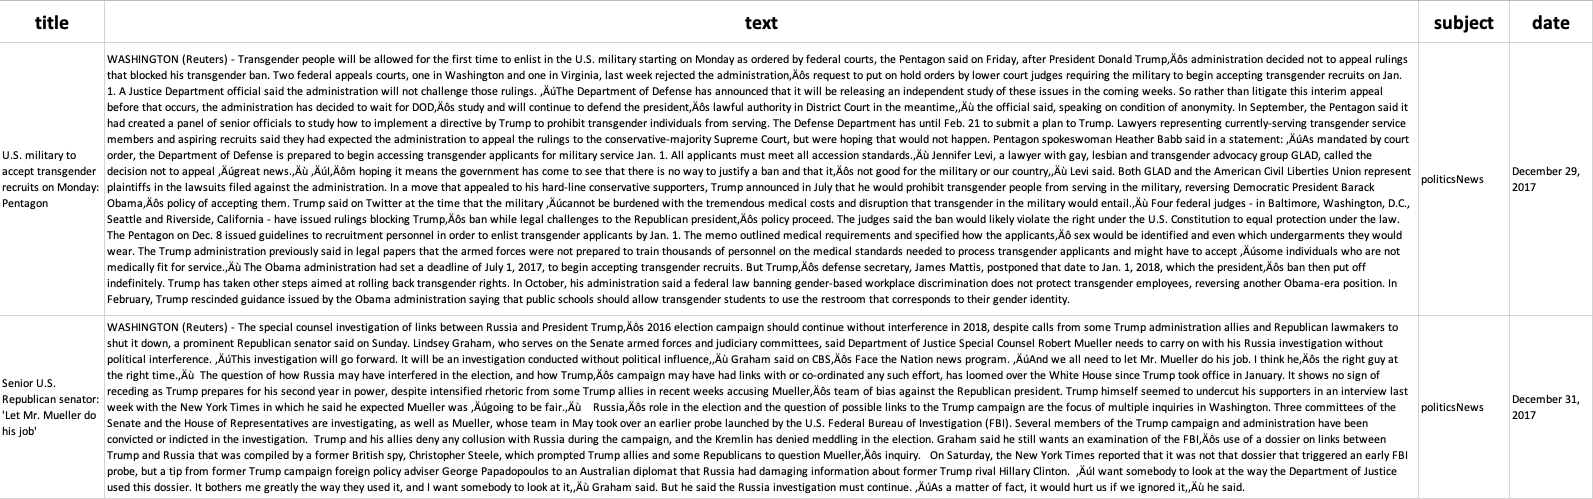

As part of the preparation stage, and in order to prevent potential bias and ensure that our network is relying primarily on the text and title for making inferences, we made the decision to remove the subject attribute from our analysis.<Br> The subject attribute in the True dataset is limited to "political news" and "world news," while the Fake dataset has a different set of categories. If we had kept the subject attribute, the network may have become too reliant on it for making accurate inferences, potentially ignoring important information in the text and title.<br> As a result, the network could have produced misleadingly accurate results based on flawed inference rules.


In [ ]:
#Define file path
file_path = '/content/gdrive/My Drive/Colab Notebooks/project/data/'

import_from_csv = False       #True - import from Raw File, False - import from clean file.

In [ ]:
#function for initial text cleaning
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
#load DataSet
num_of_article_to_load = 10000

if import_from_csv:
  df_fake = pd.read_csv(file_path + "Fake.csv")
  df_true = pd.read_csv(file_path + "True.csv")

  #To run faster, we take only part of article
  df_fake.drop(df_fake.index[num_of_article_to_load:], inplace=True, axis=0)
  df_true.drop(df_true.index[num_of_article_to_load:], inplace=True, axis=0)

  #Cleaning unrelevant data
  df_fake = df_fake.drop(['subject','date'], axis = 1)
  df_fake = df_fake.fillna(' ') #to avoid nan-problems
  df_fake['text'] = df_fake['text'].apply(wordopt)
  df_fake['title'] = df_fake['title'].apply(wordopt)
  df_fake.to_csv(file_path + "clean_fake_data.csv", index=False)

  df_true = df_true.drop(["subject","date"], axis = 1)
  df_true = df_true.fillna(' ') #to avoid nan-problems
  df_true['text'] = df_true['text'].apply(wordopt)
  df_true['title'] = df_true['title'].apply(wordopt)
  df_true.to_csv(file_path + "clean_true_data.csv", index=False)


else:
  df_true = pd.read_csv(file_path + "clean_true_data.csv")
  df_fake = pd.read_csv(file_path + "clean_fake_data.csv")

df = pd.concat([df_true, df_fake],ignore_index=True)

After the word preprocessing step, we divided the data into three sets: training, validation, and test.<br> The validation set allows us to monitor our learning progress and prevent overfitting, as well as analyze the learning rate effectively.<br> On the other hand, the test set is used to determine the accuracy of the model and is kept separate from the other sets to avoid bias during the final evaluation.

In [ ]:
print("---------  Data detail ---------")
print("The Total Data contain {} articles.".format(df.size))
print("{}/{} True article".format(df_true.size,df.size))
print("{}/{} Fake article".format(df_fake.size,df.size))
print("\narticle example:")
print(df['text'][0])

---------  Data detail ---------
The Total Data contain 40000 articles.
20000/40000 True article
20000/40000 Fake article

article example:
washington  reuters    the head of a conservative republican faction in the u s  congress  who voted this month for a huge expansion of the national debt to pay for tax cuts  called himself a  fiscal conservative  on sunday and urged budget restraint in   in keeping with a sharp pivot under way among republicans  u s  representative mark meadows  speaking on cbs   face the nation   drew a hard line on federal spending  which lawmakers are bracing to do battle over in january  when they return from the holidays on wednesday  lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues  such as immigration policy  even as the november congressional election campaigns approach in which republicans will seek to keep control of congress  president donald trump and his republicans want a big budget increase in milit

In [ ]:
#split test DataSet from other DataSet
Test_part = int(num_of_article_to_load*0.15)
df_train_val_true = df_true.iloc[Test_part:].reset_index(drop=True)
df_train_val_fake = df_fake.loc[Test_part:].reset_index(drop=True)
df_test_true = df_true.iloc[:Test_part].reset_index(drop=True)
df_test_fake = df_fake.iloc[:Test_part].reset_index(drop=True)

## Embedding methods


One of the main focus of our project is on embedding, which is a crucial aspect of our work.
Embedding words is a technique used in text analysis with machine learning to map words into numerical values.
The conventional approach is to manually assign numerical values to each word, but this method is insufficient for obtaining optimal results.

To have a better learning process, we use an embedding layer as either the first or last step in preprocessing the data. Word embedding, represented as linear layers without bias, provide a representation of words where similar words have similar encodings.
The encodings are not specified manually but learned as trainable parameters by the model during training. Embedding can have varying dimensions, ranging from 8 for small datasets to 1024 for large datasets (powers of 2 can be practical). A higher dimensional embedding can provide more detailed relationships between words, but requires more data to learn, and require additional memory.

An intriguing property of word embeddings is the Euclidean distance characteristic. By utilizing word embeddings correctly, each word can be represented in a 2-dimensional space. Examining the semantic relationships between words reveals that words with similar meanings are positioned close to each other, and the direction of the vector between two words can indicate the type of association between the word pair (as illustrated in the image).

Aside from using the traditional embedding layer, based on the number of words in the text, there are several popular pre-trained embedding layers available. Two of the most trustworthy pre-trained embedding layers are GloVe and CharNGram, which will be explained later. We employ both of them, as their performance has been satisfactory and their memory and complexity needs are suitable for our systems.

<br> A simple example of the desire result:<br>
The vectors $king-queen$ and $men-women$ have the same direction, as we can see.
<br> That make a sense, because $king-men$ and $queen-women$ share the same words relationship.
<br> In addition, note that calculate
$queen-women+men$ will yield the vector value of $king$.
<br> This example represent well the meaning relation of those words (this exampe reffer to the GloVe emmbeding methods).


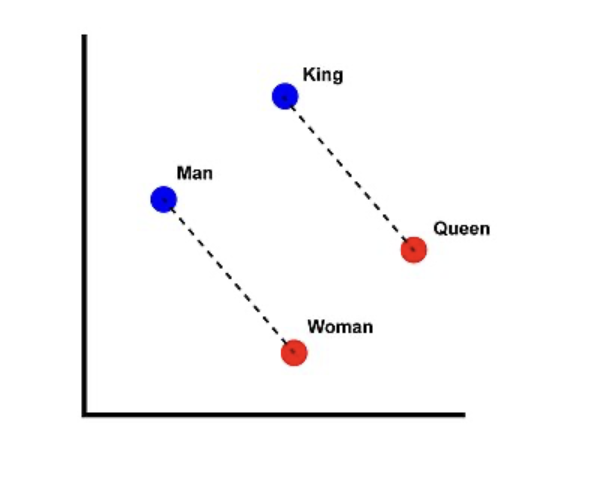

**The embedding methods:**<br>
> **1) Frequency -** This is an improvnemt to the naive methods, in this method we create a vocabulary of all the words existing in the article and sort them by frequency (i.e. the total number of time there are in use) then we transform each word by here sorted vobabulary value where the most appire word get the lowest value. in this way there is some meaning to the value assing to each word. the most frequency word get small value and have a very general meaning to the context that represent the unaffectiveness of the word when deciding if the article is fake or true ("the", "or", if" exc.), while the more rear word get higher value and have more spacific meaning that can help us infer fake or true. this methods is lake of refference to the coralation meaning between words and can loss important meaning when vactorize. (contrary to the above example).
<br>**2) GloVe -** This is the most widely used method for word vectorization. GloVe (Global Vectors for Word Representation) is a pre-trained model developed by Stanford University.
<br>**3) CharNGram -** This is another pre-trained method where we create a vocabulary of n-grams and represent each word as a vector of 1's and 0's indicating whether each n-gram is present in the word. This method uses 100 n-grams, which can be helpful in handling out-of-vocabulary words.



In [ ]:
# vactorize the articlt by the most common word vector)
FreqVocab = torchtext.vocab.build_vocab_from_iterator([df['text'].loc[i].split() for i in range(len(df))])
FreqVocab = torchtext.vocab.Vocab(FreqVocab)

In [ ]:
#preparation for using GloVe Embedding
GloVe_embedding_dim = 50
GloVe = torchtext.vocab.GloVe(name="6B", dim=GloVe_embedding_dim)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 27765.18it/s]


In [ ]:
#preparation for using CharNGram Embedding
CharNGram = torchtext.vocab.CharNGram()

.vector_cache/jmt_pre-trained_embeddings.tar.gz: 956MB [00:29, 32.7MB/s]                           
100%|█████████▉| 874473/874474 [00:39<00:00, 22397.98it/s]


##Vectorize

As previously discussed, the first step after cleaning the data is to vectorize the words, which means converting them to numerical values. One of the most efficient and widely used methods is to create a dictionary based on the frequency of each word's appearance, which takes into account the importance of each word through the use of term frequency-inverse document frequency (tf-idf).
Additionally, GloVe and CharNGram also provide vectorization options.<br>

>**GloVe**- this is the most popular method. GloVe (Global Vectors for Word Representation) is a pre-train model created by stanford university and implemented to a word2vec tool for word vectorization purpeses.<Br>
**CharNGram** - Character n-gram embeddings are trained using the same Skip-gram objective. The final character embedding is obtained by taking the average of the unique character n-gram embeddings of the word. For instance, the character n-grams (n = 1, 2, 3) of the word "hat" are {H, a, t,), (Ha, at, t)(Ha, Hat, at). The use of character embeddings effectively incorporates morphological features. Each word is then represented as "xt", which is the concatenation of its corresponding word and character embeddings, shared across all tasks. We will observe that this method is not appropriate for vectorization as it is typically used for word prediction, which involves predicting the next word given a partial sentence.



In [ ]:
def vectorize_By_Vocab(df_data, vocab, method = "Freq"):
    """
    This function take vocabulary and transform each word in an article to
    an integer according to the vocabulary
    """
    data = []
    for i in range(len(df_data)):
        vec_i = []
        for col in ['title', 'text']:
            if method in ["GloVe","CharNGram"] :
                vec_i.append(([vocab.stoi[w] for w in df_data[col].loc[i].split() if w in vocab.stoi]))
            else: # method=="Freq":
                vec_i.append(([vocab[w] for w in df_train_val_true['title'].loc[i].split() if w in vocab]))
        data.append(vec_i)
    return data

def compre_length(data, text_pad_length, title_pad_length=20):
    """
    This function compre all the article size to pad_length
    by padding the sort and cut the long.
    """
    data_size = len(data)
    for inx in range(len(data)):
        if len(data[inx][1]) > text_pad_length:
            data[inx][1] = np.array(data[inx][1][:text_pad_length])
        else:
            data[inx][1] = np.concatenate((np.array(data[inx][1]),np.zeros(text_pad_length-len(data[inx][1]))))

        if len(data[inx][0]) > title_pad_length:
            data[inx][0] = np.array(data[inx][0][:title_pad_length])
        else:
            data[inx][0] = np.concatenate((np.array(data[inx][0]),np.zeros(title_pad_length-len(data[inx][0]))))

        data[inx] = np.concatenate((data[inx][0],data[inx][1])) #concatenate title and article vector
    return data

def split_data(data,train_size):
    """
    This function split the proccess data to train and validation parts
    """
    data_size = len(data)
    train_size = int(data_size*train_size)

    train_data = np.array(data[:train_size])
    val_data = np.array(data[train_size:])
    return train_data, val_data


In [ ]:
def pre_proccess_data(df_data, pad_text_size=1000, pad_title_size=20, vectorize_method="Freq", train_part=None):  ## make it more general for test also!
    """
    This function is use to vectorize each article to integer values
    by one of 3 methods and pad each vector if needed
    for train and val data it is recomended to pass train_part=0.8
    for test data dont pass train_part value (None by default)
    """
    if vectorize_method=="GloVe":
        vocab = GloVe
    elif vectorize_method=="CharNGram":
        vocab = CharNGram
    else: # vectorize_method=="Freq":
        vocab = FreqVocab.get_stoi()

    data = vectorize_By_Vocab(df_data, vocab, vectorize_method)
    vocab_size = len(vocab)
    data = compre_length(data, pad_text_size, pad_title_size)



    if train_part==None: #for test data
        return np.array(data)
    else:
        train_data, val_data = split_data(data,train_part) #for train and val data
        return train_data, val_data, vocab_size

For the frequency method, we can see the 10 most popular words, which are are mostly Conjunctions, as we have been expected.

In [ ]:
most_common_word = [FreqVocab.get_itos()[i] for i in range(10)]
print("There are {} distinct words".format(len(FreqVocab)))
print("The 10 most popular words are:")
print(most_common_word)

There are 71104 distinct words
The 10 most popular words are:
['the', 'to', 'of', 'a', 'and', 'in', 's', 'that', 'trump', 'on']


Prior to exploring the network, it is important to examine the length of the articles and the correlation between the length and label. The length of each article can significantly impact the process since we are modifying the length of each article to 1000 through zero-padding as needed. We will analyze the impact of length on the results in the results analysis section.

In [ ]:
def listed_length(data):
    len_list = [0 for i in range(101)]
    for article in data:
        len_range = len(article)//100
        len_list[len_range if len_range<100 else 100] += 1
    return len_list

true_length = listed_length(df_true['text'])
false_length = listed_length(df_fake['text'])

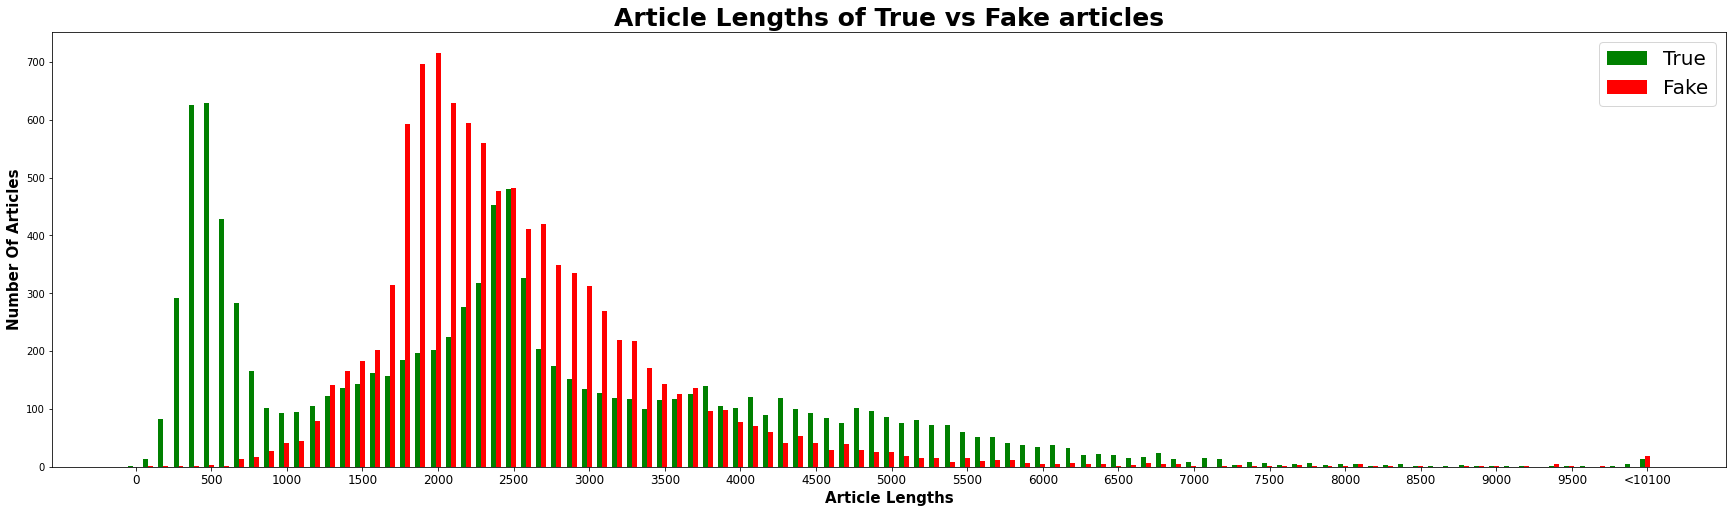

In [ ]:
plt.figure(figsize=(30, 8))
barWidth = 0.33
h1 = [i for i in range(len(true_length))]
h2 = [i + barWidth for i in h1]
group = [str(i*500) for i in range((len(true_length))//5)] + ["<"+str(len(true_length)*100)]

plt.title("Article Lengths of True vs Fake articles", fontweight ='bold', fontsize = 25)
plt.bar(h1, true_length, color = "green", label ='True', width = barWidth)
plt.bar(h2, false_length, color = "red", label ='Fake', width = barWidth)
plt.xlabel('Article Lengths', fontweight ='bold', fontsize = 15)
plt.ylabel('Number Of Articles', fontweight ='bold', fontsize = 15)
plt.xticks([i*5+barWidth for i in range(len(group))], group, fontsize = 12)

plt.legend(fontsize = 20)
plt.show()

##RNN

In addition to the embedding layer, another key component of our network is the Recurrent Neural Network (RNN) block. RNN operates on the principle of saving the output of a given layer and feeding it back to the input to predict the output of that layer. This was developed to address issues in feed-forward neural networks such as handling sequential data and the inability to consider previous inputs.

RNNs are capable of handling sequential data, taking into account both the current input and previous inputs due to their internal memory. As a result, text mining and sentiment analysis can be performed using RNNs for Natural Language Processing (NLP). The most common RNN architectures are gated recurrent units (GRUs) and long short-term memory (LSTM) networks. GRUs enhance vanilla RNNs by providing internal mechanisms to control the update of the internal state, while LSTMs maintain a latent variable known as the memory cell.

We experimented with both bidirectional and traditional RNN architectures. While bidirectional models can be used for tasks such as signal smoothing and denoising, we did not find them to be meaningful in our case.<br>
We will discuss the rest of our network in the next section.

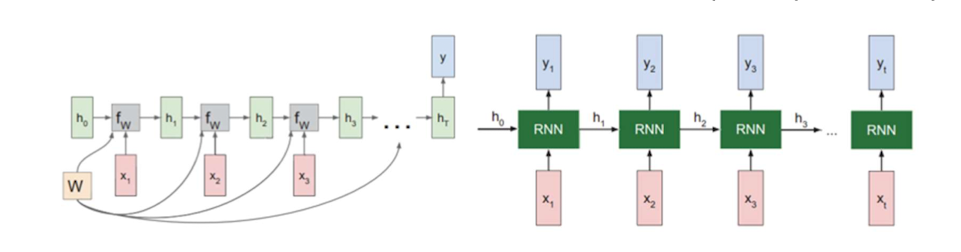

##Models implementation

We have processed the data, transformed it into vectors and constructed the embedding layer. As our data is textual, we have determined that an RNN architecture is suitable. To optimize the learning process and account for complexities, we have selected certain hyperparameters and added various layers. Based on recent research and evaluation of options, we have finally decided to use the following network for training:<br>


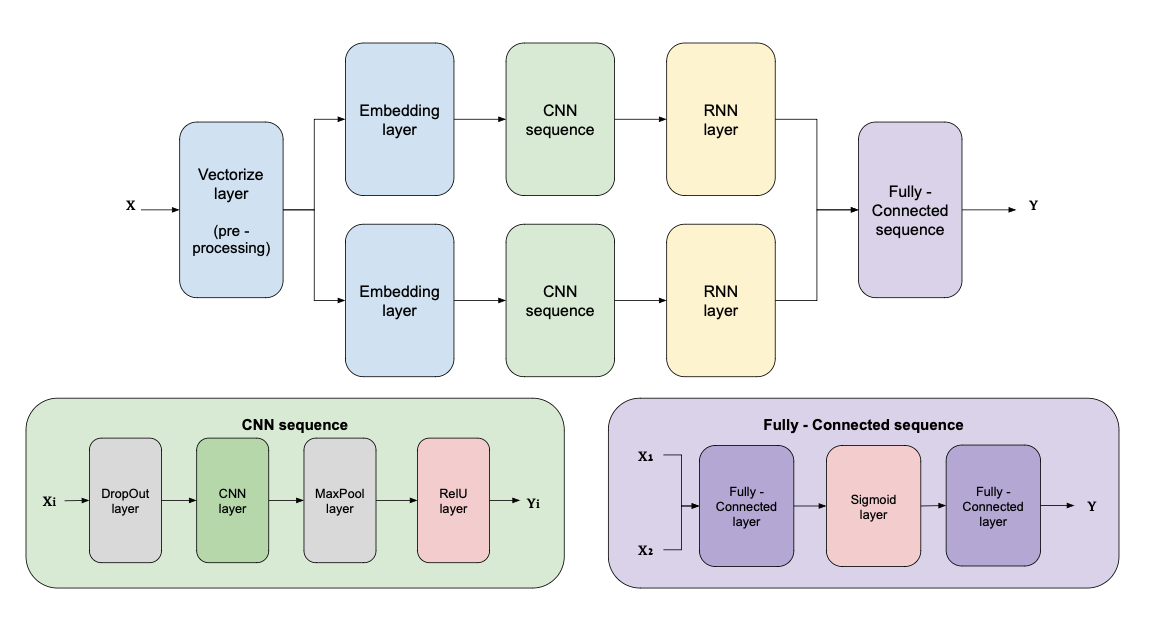

The input to the model consists of a pair of vectorized data: one for the title and another for the article. Both vectors go through the same learning process and are then combined in a fully connected layer.




<br> **Embedding**:
<br> As we have described in detail in the 'Embedding methods' section, we experimented with three different methods (Glove, Freq, and CharNGram) for embedding.
<br> After evaluating the results, we determined that the GloVe embedding method was the most effective and decided to use it in our model.

<br> **CNN**:
To address limitations in RAM memory and processing power, we incorporated a CNN layer to reduce the data size while retaining the important features. This allowed us to reduce the number of RNN hyperparameters, which can significantly impact the amount of required RAM memory and slow down the training process.<br>
<Br>In addition, we used the ordinary NN units:


> **Dropout**-
Helps to reduce overfitting and improves the generalization performance of the network.
Dropout works by randomly dropping out (setting to zero) a portion of the activations during training, which acts as a regularization technique and forces the network to learn multiple redundant representations of the input data. <br>
**Two Dimensional Convolution**- The utilization of convolution in our data can significantly improve the speed of network processing, even though there are no channels present in the data. Although the network might theoretically work without the convolution layer, it is practically impossible to implement the network without it due to the reduction in tensor size and simplification of all connected layers.<br>
**Maxpooling**- We used maxpooling option for reduce the computation required to process the data, and making the network more robust to small translations in the input data.<br>
**Activation functions**- The Relu function was employed in the network as per the usual practice and the sigmoid function was utilized in the final layer as we are dealing with a binary classification task (0 or 1).<br>
**Fully-Connected**:
We used the first fully connected layer as learnable weights to combine the output of the title and text RNNs. The resulting output was then fed to two neurons for one-hot output, with the higher value being selected as the final prediction.<br>
**Optimizer**:
Experimenting with different optimizers, we saw that clearly **Adam optimaizer** was the most suitable for the task (results will be shown in the results section). The activation function utilized in this layer is the sigmoid function, as we have mentioned.

<br> **RNN**:
<br> As mentioned, we have tried 3 different RNN models:
>**a. Basic RNN**
<br> **b. GRU**
<br> **c. LSTM**
<br><br> In the sections below we will explain in details on each model. In ligth of the results, we determined that the GRU model achieved the highest accuracy and chose to use it for the task.





**Basic RNN Model**
<br> The Basic RNN method takes as input the current value and the output value from the previous calculation. This allows the model to establish connections between previous words in the text and better understand the context, as we discussed earlier.

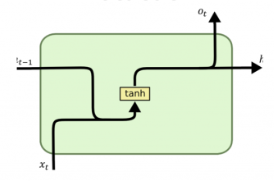

In [ ]:
class RNN(nn.Module):
    def __init__(self,batch_size = 100, kernel_size=3, embedding_dim=3, vocab_size=10000,
                 pad_title_size=20, pad_text_size=1000, Embedding_method = "Vanila"):
        """
        embedding_dim - size of the output element in Vanila Embedding method, whan using GloVe it's define at the GloVe vocab creator
        """
        super(RNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.kernel_size = kernel_size
        self.padding_size = (self.kernel_size-1)//2
        self.batch_size = batch_size
        self.element1_size = pad_text_size
        self.element2_size = pad_title_size

        #define Embedding layer
        if Embedding_method=='Vanila':
          self.emb = nn.Embedding(num_embeddings=self.vocab_size,embedding_dim=self.embedding_dim)
        elif Embedding_method=='GloVe':
          self.emb = nn.Embedding.from_pretrained(GloVe.vectors)
        elif Embedding_method=='CharNGram':
          self.emb = nn.Embedding.from_pretrained(CharNGram.vectors)

        self.Conv_block = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=self.kernel_size, padding=self.padding_size),
            nn.MaxPool2d(2,2),
            nn.ReLU()
        )

        self.RNN_block = nn.Sequential(
            nn.RNN(input_size=self.embedding_dim//2, hidden_size=self.embedding_dim//2, dropout=0.3, bidirectional = False, batch_first=True)
        )

        self.fc_block = nn.Sequential(
              nn.Linear((self.element1_size//2+self.element2_size//2)*self.embedding_dim//2, 100),
              nn.Sigmoid(),
              nn.Linear(100, 2)
        )

    def forward(self, x1, x2):
        x1 = self.emb(x1)
        x1 = x1.reshape([-1,1,self.element1_size, self.embedding_dim]) # creating 1 channel for conv layer
        x1 = self.Conv_block(x1)
        x1 = x1.reshape([-1,self.element1_size//2, self.embedding_dim//2]) # removing channels for conv layer
        x1,_ = self.RNN_block(x1)
        x1 = x1.reshape([-1,(self.element1_size//2)*(self.embedding_dim//2)]) # removing channels for conv layer

        x2 = self.emb(x2)
        x2 = x2.reshape([-1, 1, self.element2_size, self.embedding_dim]) # creating 1 channel for conv layer
        x2 = self.Conv_block(x2)
        x2 = x2.reshape([-1, self.element2_size//2, self.embedding_dim//2]) # removing channels for conv layer
        x2,_ = self.RNN_block(x2)
        x2 = x2.reshape([-1,(self.element2_size//2)*(self.embedding_dim//2)]) # removing channels for conv layer

        x = torch.cat((x1,x2),1)
        x = self.fc_block(x)
        return x

**GRU Model**
<br> The GRU architecture improves upon the traditional RNN by incorporating internal mechanisms that control the updating of the internal state. The first mechanism is the update gate, which determines whether or not to update the internal state based on the current input, enabling the skipping of unimportant inputs while retaining information from important past inputs. The second mechanism is the reset gate, whose role is to allow the system to learn when to reset its internal state, for example, when transitioning to a new chapter while processing a book (as we discussed in the lecture), in order to relinquish its dependence on past inputs.

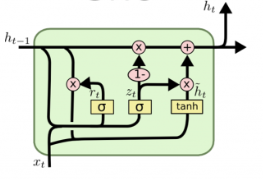

In [ ]:
class GRU(nn.Module):
    def __init__(self,batch_size = 100, kernel_size=3, embedding_dim=3, vocab_size=10000,
                 pad_title_size=20, pad_text_size=1000, Embedding_method = "Vanila"):
        """
        embedding_dim - size of the output element in Vanila Embedding method, whan using GloVe it's define at the GloVe vocab creator
        """
        super(GRU, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.kernel_size = kernel_size
        self.padding_size = (self.kernel_size-1)//2
        self.batch_size = batch_size
        self.element1_size = pad_text_size
        self.element2_size = pad_title_size

        #define Embedding layer
        if Embedding_method=='Vanila':
          self.emb = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        elif Embedding_method=='GloVe':
          self.emb = nn.Embedding.from_pretrained(GloVe.vectors)
        elif Embedding_method=='CharNGram':
          self.emb = nn.Embedding.from_pretrained(CharNGram.vectors)

        self.Conv_block = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=self.kernel_size, padding=self.padding_size),
            nn.MaxPool2d(2,2),
            nn.ReLU()
        )

        self.RNN_block = nn.Sequential(
            nn.GRU(input_size=self.embedding_dim//2, hidden_size=self.embedding_dim//2, dropout=0.3, bidirectional = False, batch_first=True)
        )

        self.fc_block = nn.Sequential(
              nn.Linear((self.element1_size//2+self.element2_size//2)*self.embedding_dim//2, 100),
              nn.Sigmoid(),
              nn.Linear(100, 2)
        )

    def forward(self, x1, x2):
        x1 = self.emb(x1)
        x1 = x1.reshape([-1,1,self.element1_size, self.embedding_dim]) # creating 1 channel for conv layer
        x1 = self.Conv_block(x1)
        x1 = x1.reshape([-1,self.element1_size//2, self.embedding_dim//2]) # removing channels for conv layer
        x1,_ = self.RNN_block(x1)
        x1 = x1.reshape([-1,(self.element1_size//2)*(self.embedding_dim//2)]) # removing channels for conv layer torch.Size([100, 12500])

        x2 = self.emb(x2)
        x2 = x2.reshape([-1, 1, self.element2_size, self.embedding_dim]) # creating 1 channel for conv layer
        x2 = self.Conv_block(x2)
        x2 = x2.reshape([-1, self.element2_size//2, self.embedding_dim//2]) # removing channels for conv layer
        x2,_ = self.RNN_block(x2)
        x2 = x2.reshape([-1,(self.element2_size//2)*(self.embedding_dim//2)]) # removing channels for conv layer torch.Size([100, 12500])

        x = torch.cat((x1,x2),1)
        x = self.fc_block(x)
        return x

**LSTM Model**
<br> LSTM networks possess a latent variable referred to as the memory cell, represented by "ct", in addition to the latent state "ht". The memory cell, which is passed and updated across time steps, influences the evolution of the hidden state. Like GRUs, LSTMs also maintain gate vectors with values between 0 and 1, of the same dimension as "ht". These gate vectors enable the balancing of the input, hidden state, and memory cell's impact on the updated hidden state.

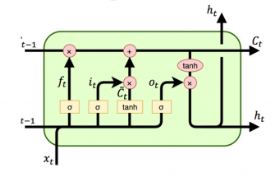

In [ ]:
class LSTM(nn.Module):
    def __init__(self,batch_size = 100, kernel_size=3, embedding_dim=3, vocab_size=10000,
                 pad_title_size=20, pad_text_size=1000, Embedding_method = "Vanila"):
        """
        embedding_dim - size of the output element in Vanila Embedding method, whan using GloVe it's define at the GloVe vocab creator
        """
        super(LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.kernel_size = kernel_size
        self.padding_size = (self.kernel_size-1)//2
        self.batch_size = batch_size
        self.element1_size = pad_text_size
        self.element2_size = pad_title_size

        #define Embedding layer
        if Embedding_method=='Vanila':
          self.emb = nn.Embedding(num_embeddings=self.vocab_size,embedding_dim=self.embedding_dim)
        elif Embedding_method=='GloVe':
          self.emb = nn.Embedding.from_pretrained(GloVe.vectors)
        elif Embedding_method=='CharNGram':
          self.emb = nn.Embedding.from_pretrained(CharNGram.vectors)

        self.Conv_block = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=self.kernel_size, padding=self.padding_size),
            nn.MaxPool2d(2,2),
            nn.ReLU()
        )

        self.RNN_block = nn.Sequential(
            nn.LSTM(input_size=self.embedding_dim//2, hidden_size=self.embedding_dim//2, dropout=0.3, bidirectional = False, batch_first=True)
        )

        self.fc_block = nn.Sequential(
              nn.Linear((self.element1_size//2+self.element2_size//2)*self.embedding_dim//2, 100),
              nn.Sigmoid(),
              nn.Linear(100, 2)
        )

    def forward(self, x1, x2):
        x1 = self.emb(x1)
        x1 = x1.reshape([-1,1,self.element1_size, self.embedding_dim]) # creating 1 channel for conv layer
        x1 = self.Conv_block(x1)
        x1 = x1.reshape([-1,self.element1_size//2, self.embedding_dim//2]) # removing channels for conv layer
        x1,_ = self.RNN_block(x1)
        x1 = x1.reshape([-1,(self.element1_size//2)*(self.embedding_dim//2)]) # removing channels for conv layer torch.Size([100, 12500])

        x2 = self.emb(x2)
        x2 = x2.reshape([-1, 1, self.element2_size, self.embedding_dim]) # creating 1 channel for conv layer
        x2 = self.Conv_block(x2)
        x2 = x2.reshape([-1, self.element2_size//2, self.embedding_dim//2]) # removing channels for conv layer
        x2,_ = self.RNN_block(x2)
        x2 = x2.reshape([-1,(self.element2_size//2)*(self.embedding_dim//2)]) # removing channels for conv layer torch.Size([100, 12500])

        x = torch.cat((x1,x2),1)
        x = self.fc_block(x)
        return x

##Accuracy metric & loss function

**Loss function** -
<br> There are different loss functions that can be used for binary classification tasks, but the most commonly use one is the **Binary Cross Entropy** Loss.<br>
Its widely used in deep learning models, as we saw during the course, and is appropriate for binary classification tasks because it measures the dissimilarity between the true label and the predicted probability of the positive class. <br>

In [ ]:
def get_class_accuracy(model, data, data_size, is_true, batch_size=100, title_length=20):
    correct = 0
    for i in range(0, data_size, batch_size):
        if (i + batch_size) > data_size:
          break
        xs = data[i:i+batch_size]

        xs1 = np.array([(element[title_length:]) for element in xs]) #articles
        xs2 = np.array([(element[:title_length]) for element in xs]) #title
        #convert to torch comptible type
        xs1 = torch.from_numpy(xs1).long().to(device)
        xs2 = torch.from_numpy(xs2).long().to(device)

        zs = model(xs1, xs2)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        if torch.cuda.is_available():
            pred = pred.detach().cpu().numpy()
        else:
            pred = pred.detach().cpu().numpy()
        correct += (pred == is_true).sum()
    return correct /data_size

def get_accuracy(model, true_data, fake_data, batch_size=100, title_length=20):
    model.eval()
    true_size = len(true_data)
    fake_size = len(fake_data)

    pos_acc = get_class_accuracy(model, true_data, true_size, 1, batch_size, title_length)
    neg_acc = get_class_accuracy(model, fake_data, fake_size, 0, batch_size, title_length)
    return  pos_acc, neg_acc

In [ ]:
CEL = nn.CrossEntropyLoss()

def get_loss(zs, st):
    loss = CEL(zs,st)
    return loss

##Train functions

###Train functions

In [ ]:
# create batch and class vector
def get_batch(pos_data, neg_data, inx_min, inx_max):
  half_batch_size = inx_max - inx_min
  st = np.concatenate((np.array([[0,1] for i in range(half_batch_size)]), np.array([[1,0] for i in range(half_batch_size)])), axis=0)
  xt = np.concatenate((pos_data[inx_min:inx_max],neg_data[inx_min:inx_max]), axis=0)
  permutation = np.random.permutation(2*half_batch_size)
  return xt[permutation], st[permutation]

In [ ]:
# clean result print
def print_acc_data(iter,train_acc,val_acc, loss):
  print("(iter %4d)|___Positive__|___Negative__|___Average___|  loss = %f" %(iter,loss))
  print("   train   |   {:6.2f}%   |   {:6.2f}%   |   {:6.2f}%   |".format(train_acc[0]*100, train_acc[1]*100, train_acc[2]*100))
  print("   val     |   {:6.2f}%   |   {:6.2f}%   |   {:6.2f}%   |\n".format(val_acc[0]*100, val_acc[1]*100, val_acc[2]*100))

In [ ]:
def train(model, train_true, train_fake, val_true, val_fake, title_length,
          num_epochs, batch_size, learning_rate, weight_decay=0,
          optimizer = "Adam", checkpoint_path=None):

  #define optimizer
  if optimizer == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
  elif optimizer == "Adagrad":
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate, weight_decay=weight_decay)

  #lists to save the train proccess result
  iters, losses = [], []
  train_accs, val_accs  = [] ,[]
  n=0

  for epoch in range(num_epochs):

    #shuffle the data each epoch
    train_size = len(train_true)
    per = np.random.permutation(train_size)
    train_true = train_true[per]
    train_fake = train_fake[per]

    per = np.random.permutation(len(val_true))
    val_true = val_true[per]
    val_fake = val_fake[per]

    print("============= start epoch num {}/{} =============".format(epoch+1,num_epochs))
    for i in range(0, train_size, batch_size//2):
        if (i + batch_size//2) > train_size:
            break

        # get the input and targets of a minibatch
        xt, st = get_batch(train_true, train_fake, i, i + batch_size//2)
        xt1 = np.array([(element[title_length:]) for element in xt]) #articles
        xt2 = np.array([(element[:title_length]) for element in xt]) #title

        #convert to torch comptible type
        xt1 = torch.from_numpy(xt1).long().to(device)
        xt2 = torch.from_numpy(xt2).long().to(device)
        st = torch.FloatTensor(st).to(device) # becuse we use one-hot encodind.

        #Train
        model.train()
        xt = model(xt1,xt2)           # compute prediction logit
        optimizer.zero_grad()         # a clean up step for PyTorch
        loss = get_loss(xt,st)        # compute the total loss
        loss.backward()               # compute updates for each parameter
        optimizer.step()              # make the updates for each parameter

        if n % 10 == 0:
            model.eval()
            iters.append(n)
            if torch.cuda.is_available():
                train_cost = float(loss.detach().cpu().numpy())
            else:
                train_cost = float(loss.detach().numpy())
            losses.append(train_cost)
            #train-acc
            pos_train_acc, neg_train_acc = get_accuracy(model, train_true, train_fake, batch_size, title_length)
            avg_train_acc = (pos_train_acc+neg_train_acc)/2
            train_accs.append([pos_train_acc, neg_train_acc, avg_train_acc])
            #val-acc
            pos_val_acc, neg_val_acc = get_accuracy(model, val_true, val_fake, batch_size, title_length)
            avg_val_acc = (pos_val_acc+neg_val_acc)/2
            val_accs.append([pos_val_acc, neg_val_acc, avg_val_acc])

            #print accuracy data every 1050 iteration
            if n % 100 == 0:
                print_acc_data(n,[pos_train_acc, neg_train_acc, avg_train_acc],[pos_val_acc, neg_val_acc, avg_val_acc], train_cost)
        n += 1

  #save the current model in the end of the train
  if (checkpoint_path is not None):
      torch.save(model.state_dict(), checkpoint_path.format(epoch))

  #print accuracy data at end of train
  print_acc_data(n,[pos_train_acc, neg_train_acc, avg_train_acc],[pos_val_acc, neg_val_acc, avg_val_acc], train_cost)

  return iters, np.array(train_accs), np.array(val_accs), losses

In [ ]:
#This function is for clear plot
import warnings
warnings.filterwarnings("ignore") ## ignore matplotlib warning for clearer show

def plot_learning_curve(iters_sub, train_accs, val_accs, loss):
    fig, ((acc_plot, cost_plt), (acc_pos_plot, acc_neg_plot)) = plt.subplots(2,2,figsize=(14,10))

    fig.suptitle("Learning Curve: Accuracy & Loss per Ephocs")
    acc_pos_plot.plot(iters_sub,train_accs[:,0], label="pos_Train")
    acc_pos_plot.plot(iters_sub,val_accs[:,0], label="pos_Val")
    acc_pos_plot.set(xlabel='Ephocs', ylabel='accuracy')
    acc_pos_plot.title.set_text('positive acc')
    acc_pos_plot.set_ylim([0,1.1])

    acc_neg_plot.plot(iters_sub,train_accs[:,1], label="neg_Train")
    acc_neg_plot.plot(iters_sub,val_accs[:,1], label="neg_Val")
    acc_neg_plot.set(xlabel='Ephocs', ylabel='accuracy')
    acc_neg_plot.title.set_text('negative acc')
    acc_neg_plot.set_ylim([0,1.1])

    acc_plot.plot(iters_sub,train_accs[:,2], label="avg_Train")
    acc_plot.plot(iters_sub,val_accs[:,2], label="avg_Val")
    acc_plot.set(xlabel='Ephocs', ylabel='accuracy')
    acc_plot.title.set_text('average acc')
    acc_plot.set_ylim([0,1.1])

    cost_plt.plot(iters_sub,loss, label="Loss", color = 'green')
    cost_plt.set(xlabel='Ephocs', ylabel='Loss')
    cost_plt.title.set_text('traning Loss')
    cost_plt.set_ylim([0,1.1])

    labels = ["Train", "Validation", "Loss"]
    fig.legend([acc_plot, cost_plt],labels=labels, loc="upper right")


###Train preparation function

In [ ]:
#This Function prepare all the data for training and plot the training deateil
def train_model(model_name, df_true, df_fake,
                pad_text_size=1000, pad_title_size=20, train_part=0.8,
                kernel_size=3, optimizer = "Adam",
                embedding_dim=3, Embedding_method="Vanila", Vectorize_method="Freq",
                epochs=10, batch_size=100,
                lr=0.001, weight_decay=0,
                checkpoint_bool=False):

  if Embedding_method=="Vanila":
      embedding_dim_input = embedding_dim
  elif Embedding_method=="GloVe":
      embedding_dim_input = GloVe_embedding_dim
  elif Embedding_method =='CharNGram':
      embedding_dim_input = 100   # pre-define size

  #data pre-proccessing
  train_true, val_true, vocab_size = pre_proccess_data(df_true, pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                                            vectorize_method=Vectorize_method, train_part=train_part)
  train_fake, val_fake, vocab_size = pre_proccess_data(df_fake, pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                                            vectorize_method=Vectorize_method, train_part=train_part)

  if model_name=="RNN":
      model = RNN(batch_size=batch_size, kernel_size=kernel_size, embedding_dim=embedding_dim_input, vocab_size=vocab_size,
                  pad_title_size=pad_title_size, pad_text_size=pad_text_size ,Embedding_method=Embedding_method)
  elif model_name=="GRU":
      model = GRU(batch_size=batch_size, kernel_size=kernel_size, embedding_dim=embedding_dim_input, vocab_size=vocab_size,
                  pad_title_size=pad_title_size, pad_text_size=pad_text_size ,Embedding_method=Embedding_method)
  elif model_name=="LSTM":
      model = LSTM(batch_size=batch_size, kernel_size=kernel_size, embedding_dim=embedding_dim_input, vocab_size=vocab_size,
                  pad_title_size=pad_title_size, pad_text_size=pad_text_size ,Embedding_method=Embedding_method)

  if torch.cuda.is_available():
      model = model.cuda()


  if checkpoint_bool==True:
    checkpoint_path = file_path+'ckpt'+'_model='+model_name+ \
                        '_emb='+Embedding_method+'_opt='+optimizer+'_lr='+str(lr)+'_pads='+str(pad_text_size)+'_batchs='+str(batch_size)+'.pk'
  else:
    checkpoint_path=None

  learning_curve_info = train(model,
                            train_true=train_true,  train_fake=train_fake,
                            val_true=val_true,      val_fake=val_fake,
                            title_length=pad_title_size,
                            num_epochs=epochs,      batch_size=batch_size,
                            learning_rate=lr,       weight_decay=weight_decay,
                            optimizer = optimizer,
                            checkpoint_path =checkpoint_path)


  print("==========================================================")
  print("                  Model & Train Summary:")
  print("==========================================================")
  print("===================== Pre-Proccesing =====================")
  print("Vectorize method: {}, Embedding method: {}".format(Vectorize_method,Embedding_method))
  print("Text Padding size={}, Title Padding size={}".format(pad_text_size,pad_title_size))
  print("=====================  Train Params  =====================")
  print("Num of Epochs={}, batch size={}".format(epochs,batch_size))
  print("learning rate={}, weight decay={}\n".format(lr,weight_decay))
  print("=====================  Model Params  =====================")
  print("Model: {}, Optimizer={}".format(model_name,optimizer))
  print("Kernel Size={}".format(kernel_size))
  summary(model,input_size=[(1,pad_text_size),(1,pad_title_size)])
  plot_learning_curve(*learning_curve_info)
  plt.show()

  return model

##Results analyzer

After reviewing the pre-processing and network structure, we aim to examine the various factors that influence the model's accuracy and analyze the results. To gain a better understanding of the learning process, we experimented with changing the network parameters.<br>
In order to maintain clarity in the document, we have decided to include only the key simulations that we deem relevant.


### Final results

Chronically, we achieved the best results in the end, but the interesting results are actually the poor ones,<br> which will discussed further:



============= start epoch num 1/10 =============
(iter    0)|___Positive__|___Negative__|___Average___|  loss = 0.701458
   train   |    99.76%   |     0.00%   |    49.88%   |
   val     |    97.88%   |     0.00%   |    48.94%   |

(iter  100)|___Positive__|___Negative__|___Average___|  loss = 0.232358
   train   |    79.90%   |    98.49%   |    89.19%   |
   val     |    61.82%   |    90.53%   |    76.18%   |

============= start epoch num 2/10 =============
(iter  200)|___Positive__|___Negative__|___Average___|  loss = 0.075652
   train   |    92.26%   |    97.85%   |    95.06%   |
   val     |    82.00%   |    88.71%   |    85.35%   |

============= start epoch num 3/10 =============
(iter  300)|___Positive__|___Negative__|___Average___|  loss = 0.080581
   train   |    84.91%   |    99.40%   |    92.15%   |
   val     |    68.94%   |    95.00%   |    81.97%   |

============= start epoch num 4/10 =============
(iter  400)|___Positive__|___Negative__|___Average___|  loss = 0.074766


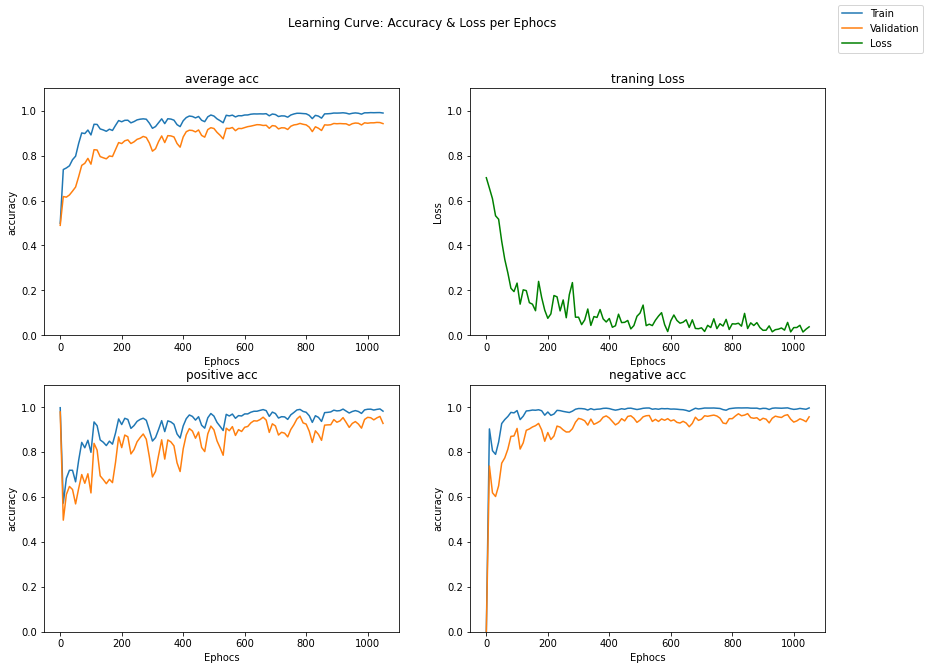

In [ ]:
#Padding Parameter definitaion
pad_text_size = 1000
pad_title_size = 30

BestModel = train_model(model_name = 'GRU',
                        df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                        pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                        kernel_size=3, optimizer = 'Adam',
                        embedding_dim=50, Embedding_method='GloVe', Vectorize_method='GloVe',
                        epochs=10, batch_size=128,
                        lr=0.001, weight_decay=0,
                        checkpoint_bool=True)

In [ ]:
#Test Data Pre-Proccesing
test_true = pre_proccess_data(df_test_true, pad_text_size=pad_text_size,
                              pad_title_size=pad_title_size, vectorize_method="GloVe")
test_fake = pre_proccess_data(df_test_fake, pad_text_size=pad_text_size,
                              pad_title_size=pad_title_size, vectorize_method="GloVe")

 ****    test accuracy report    ****

___Positive__|___Negative__|___Average___ 
    96.53%   |    99.73%   |    98.13%   

Confusion Matrix plot:


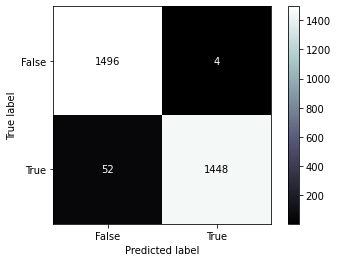

In [ ]:
pos_test_acc, neg_test_acc = get_accuracy(BestModel,test_true,test_fake, batch_size=100, title_length=pad_title_size)
avg_test_acc = (pos_test_acc+neg_test_acc)/2

print(" ****    test accuracy report    ****\n")
print("___Positive__|___Negative__|___Average___ ")
print("   {:6.2f}%   |   {:6.2f}%   |   {:6.2f}%   ".format(pos_test_acc*100, neg_test_acc*100, avg_test_acc*100))

print("\nConfusion Matrix plot:")
n_true = len(test_true)
n_fake = len(test_fake)
actual = np.concatenate((np.ones(n_true),np.zeros(n_fake)))
predicted = np.concatenate((np.ones(int(n_true*pos_test_acc+0.5)),np.zeros(int(n_true*(1-pos_test_acc)+0.5)),np.zeros(int(n_fake*neg_test_acc+0.5)),np.ones(int(n_fake*(1-neg_test_acc)+0.5))))
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap='bone')
plt.show()

The results of our study indicate that with proper parameter selection and proper choice of embedding and vectorization techniques, a test accuracy of approximately 98% can be achieved (state of art). These results are consistent with those of other classic machine learning algorithms that have been applied to this problem (as referenced at the end of the project). However, we aim to further examine the factors that contribute to these results by exploring what is disrupting our network.

###Additional results

#### Model Choosing

We would like to establish the performance of each model and assess their respective usefulness.

In [ ]:
emb='GloVe'
opt='Adam'
lr=0.001

for model in ['GRU','LSTM','RNN']:
    model_model = train_model(model_name = model,
                    df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                    pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                    kernel_size=3, optimizer = opt,
                    embedding_dim=50, Embedding_method=emb, Vectorize_method=emb,
                    epochs=7, batch_size=128,
                    lr=lr, weight_decay=0,
                    checkpoint_bool=False)

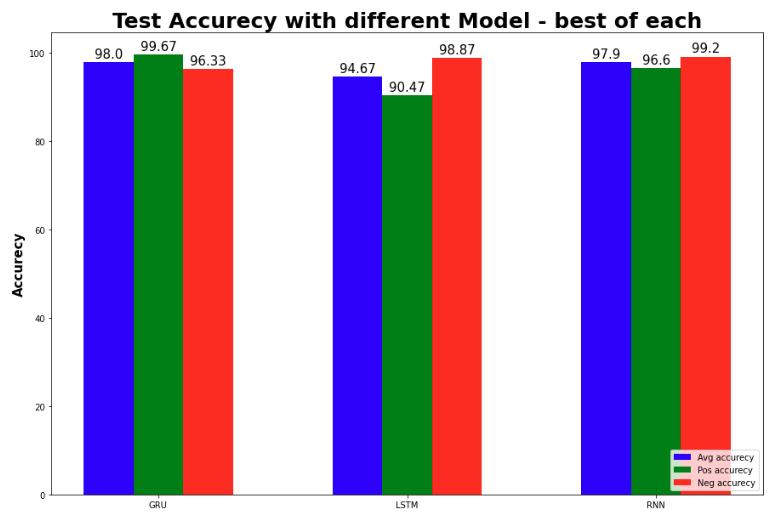

#### Learning rate  

In our efforts to attain good results, we experimented with various learning rate values.<br> It became apparent that the optimal learning rate depends on the inputs, making it a crucial consideration in the process:

In [ ]:
model='GRU'
emb='GloVe'
opt='Adam'

for lr in [0.001,0.0001,0.00001]:
    lt_model = train_model(df_test_true, df_test_fake,
                    model_name = model,
                    df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                    pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                    kernel_size=3, optimizer = opt,
                    embedding_dim=50, Embedding_method=emb, Vectorize_method=emb,
                    epochs=7, batch_size=128,
                    lr=lr, weight_decay=0,
                    checkpoint_bool=False)


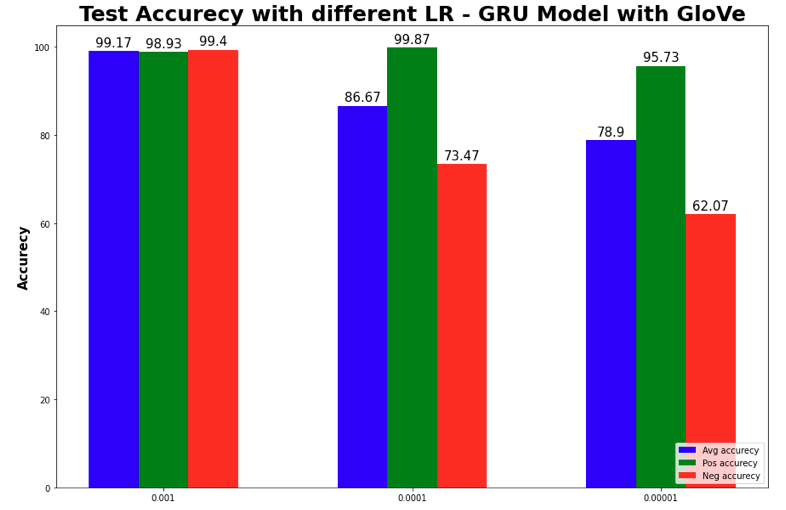

#### Optimizers

During our investigation, we experimented with various optimization algorithms. During the process, we utilized the Adam optimizer, but we also wanted to evaluate other options, such as the basic stochastic gradient descent (SGD) and the Adagrad optimizer. Our findings showed that both Adam and Adagrad were effective, delivering satisfactory results. <br><br>

**SGD** (Stochastic Gradient Descent)- A basic optimization algorithm that updates model weights based on the negative gradient of the loss function using a learning rate hyperparameter to determine step size. It is effective for simple models with large data, but can have slow convergence and be sensitive to the choice of learning rate.<br><br>

**Adagrad** (Adaptive Gradient Algorithm)- An extension of SGD. Unlike SGD, which uses a fixed learning rate for all parameters, Adagrad adjusts the learning rate for each parameter individually, allowing for faster convergence for sparse gradients and online learning scenarios. The learning rate of each parameter in Adagrad is updated based on the historical gradient information, with the learning rate declining over time for well-behaved gradients. This can lead to more robust convergence and faster training in some cases.<br><br>

**Adam** (Adaptive Moment Estimation)- Combines the ideas of gradient descent and moving average based optimization. Adam uses moving averages of the gradients and squared gradients to dynamically adapt the learning rate for each weight, allowing for faster convergence and less sensitivity to the choice of learning rate compared to stochastic gradient descent (SGD). This makes Adam a popular choice for training complex deep learning models.<br><br>

Adam and Adagrad are popular optimization algorithms. Adam is powerful and suitable for complex deep learning models, while Adagrad is ideal for sparse gradient problems and online learning. The best choice depends on the specific problem and the characteristics of the data and model. It's common to try both algorithms and compare their performance.

In [ ]:
model='GRU'
emb='GloVe'
lr='0.001'

for opt in ['Adam','SGD','Adagrad']:
    opt_model = train_model(df_test_true, df_test_fake,
                    model_name = model,
                    df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                    pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                    kernel_size=3, optimizer = opt,
                    embedding_dim=50, Embedding_method=emb, Vectorize_method=emb,
                    epochs=7, batch_size=128,
                    lr=lr, weight_decay=0,
                    checkpoint_bool=False)


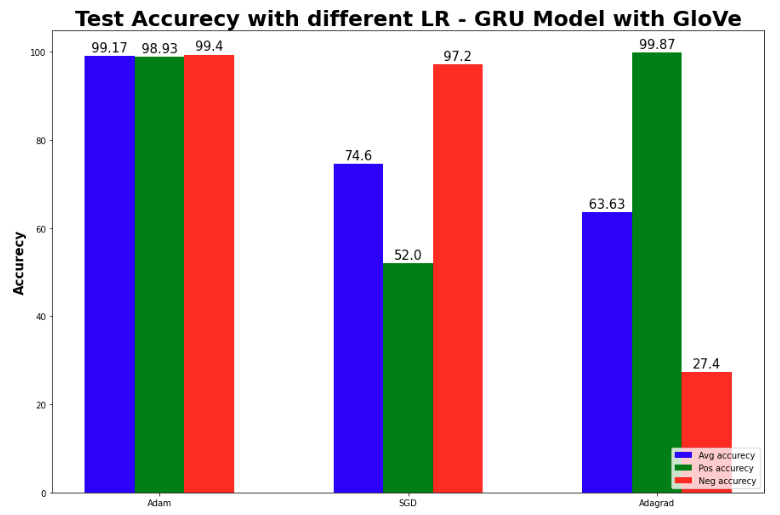

#### Embedding Methods

We have disscussed the importance of the embedding layer, but what is actually the impact of using that layer?<br>
Our experimentation has shown that without an embedding layer, the learning process is not effective.

In [ ]:
model='GRU'
opt='Adam'

for emb in [['GloVe',0.001], ['Vanila',0.0001], ['CharNGram',0.0001]]:
    emb_model = train_model(df_test_true, df_test_fake,
                    model_name = model,
                    df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                    pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                    kernel_size=3, optimizer = opt,
                    embedding_dim=50, Embedding_method=emb[0], Vectorize_method=emb[0],
                    epochs=7, batch_size=128,
                    lr=emb[1], weight_decay=0,
                    checkpoint_bool=False)

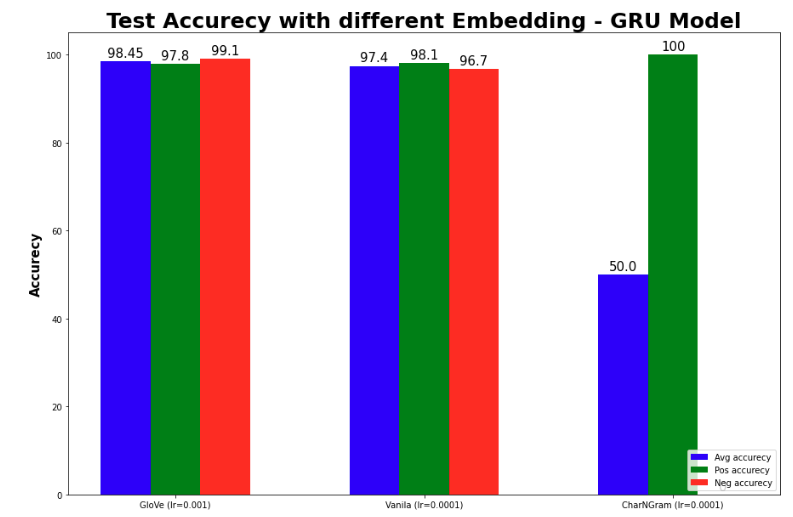

The Learning process of CharNGram Model is present in "Appendic A"

#### Different data type

We have observed that utilizing two separate sources results in significantly inferior performance. Typically, when we divide a dataset into training-validation and test data, we attain satisfactory results.<br> However, when the test data is not taken from the original training set, we do not achieve the same level of accuracy.<Br> One possible explanation for this discrepancy is the size of our network,<br> which may not be sufficient to produce good results for diverse types of data.
<br> In particular, we employ 2D convolution to reduce the dimensions before utilizing our RNN network. However, this reduction in dimensionality results in the loss of certain patterns while preserving only unique patterns that are specific to our data. As a result, our model may perform slightly worst only on a particular kind of text and may not generalize well to other datasets.

In [ ]:
#import dataset 2 with similar attribute
#data source - https://www.kaggle.com/competitions/fake-news/data

file_path = '/content/gdrive/My Drive/Colab Notebooks/project/data2_amichai/'

import_from_csv = True
num_of_article_to_load = 10000

if import_from_csv:
  df = pd.read_csv(file_path + "train.csv")
  df_fake = df.loc[df['label'] == 0]
  df_true = df.loc[df['label'] == 1]

  #To run faster, we take only part of article
  df_fake.drop(df_fake.index[num_of_article_to_load:], inplace=True, axis=0)
  df_true.drop(df_true.index[num_of_article_to_load:], inplace=True, axis=0)

  #Cleaning unrelevant data
  df_fake = df_fake.drop(['id', 'author','label'], axis = 1)
  df_fake = df_fake.fillna(' ') #to avoid nan-problems
  df_fake['text'] = df_fake['text'].apply(wordopt)
  df_fake['title'] = df_fake['title'].apply(wordopt)
  df_fake.to_csv(file_path + "clean_fake_data2.csv", index=False)

  df_true = df_true.drop(['id', 'author', 'label'], axis = 1)
  df_true = df_true.fillna(' ') #to avoid nan-problems
  df_true['text'] = df_true['text'].apply(wordopt)
  df_true['title'] = df_true['title'].apply(wordopt)
  df_true.to_csv(file_path + "clean_true_data2.csv", index=False)


else:
  df_true = pd.read_csv(file_path + "clean_true_data2.csv")
  df_fake = pd.read_csv(file_path + "clean_fake_data2.csv")

df = pd.concat([df_true, df_fake],ignore_index=True)

#split test DataSet from other DataSet
Test_part = int(num_of_article_to_load*0.15)
df_train_val_true = df_true.iloc[Test_part:].reset_index(drop=True)
df_train_val_fake = df_fake.loc[Test_part:].reset_index(drop=True)
df_test_true = df_true.iloc[:Test_part].reset_index(drop=True)
df_test_fake = df_fake.iloc[:Test_part].reset_index(drop=True)

============= start epoch num 1/8 =============
(iter    0)|___Positive__|___Negative__|___Average___|  loss = 0.722128
   train   |    99.76%   |     0.00%   |    49.88%   |
   val     |    97.88%   |     0.00%   |    48.94%   |

(iter  100)|___Positive__|___Negative__|___Average___|  loss = 0.615271
   train   |    27.63%   |    93.72%   |    60.68%   |
   val     |    29.06%   |    90.88%   |    59.97%   |

============= start epoch num 2/8 =============
(iter  200)|___Positive__|___Negative__|___Average___|  loss = 0.527966
   train   |    58.13%   |    86.76%   |    72.45%   |
   val     |    56.41%   |    83.82%   |    70.12%   |

============= start epoch num 3/8 =============
(iter  300)|___Positive__|___Negative__|___Average___|  loss = 0.414181
   train   |    84.25%   |    76.71%   |    80.48%   |
   val     |    79.00%   |    73.53%   |    76.26%   |

============= start epoch num 4/8 =============
(iter  400)|___Positive__|___Negative__|___Average___|  loss = 0.466860
   t

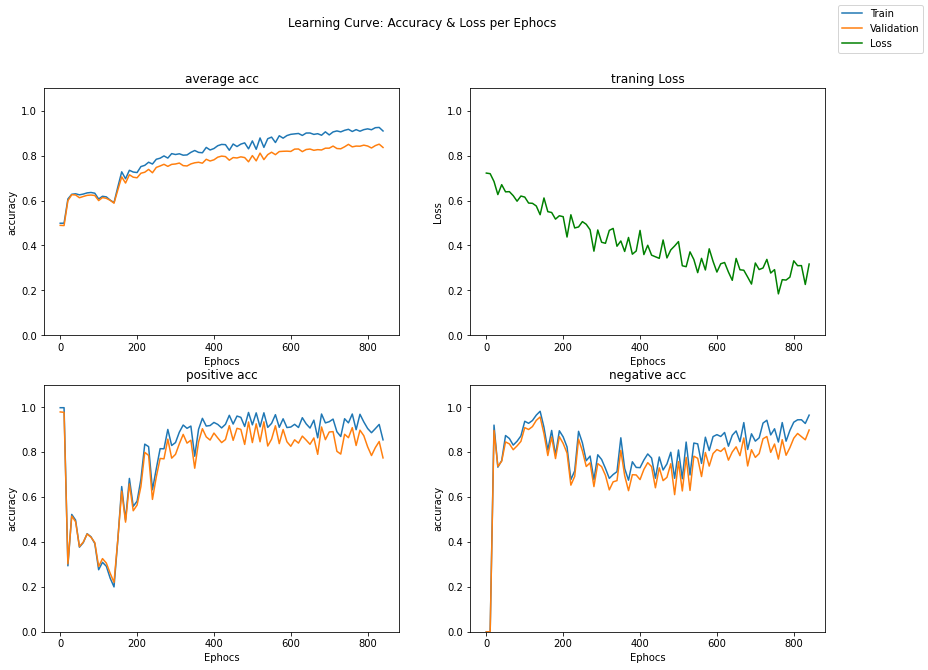

In [ ]:
#Padding Parameter definitaion
pad_text_size = 1000
pad_title_size = 30

BestModel = train_model(model_name = 'GRU',
                        df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                        pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                        kernel_size=3, optimizer = 'Adam',
                        embedding_dim=50, Embedding_method='GloVe', Vectorize_method='GloVe',
                        epochs=8, batch_size=128,
                        lr=0.001, weight_decay=0,
                        checkpoint_bool=True)

In [ ]:
#Test Data Pre-Proccesing
test_true = pre_proccess_data(df_test_true, pad_text_size=pad_text_size,
                              pad_title_size=pad_title_size, vectorize_method="GloVe")
test_fake = pre_proccess_data(df_test_fake, pad_text_size=pad_text_size,
                              pad_title_size=pad_title_size, vectorize_method="GloVe")

 ****    test accuracy report    ****

___Positive__|___Negative__|___Average___ 
    86.40%   |    90.27%   |    88.33%   

Confusion Matrix plot:


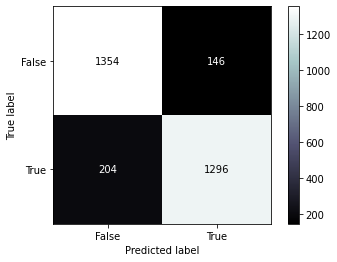

In [ ]:
pos_test_acc, neg_test_acc = get_accuracy(BestModel,test_true,test_fake, batch_size=100, title_length=pad_title_size)
avg_test_acc = (pos_test_acc+neg_test_acc)/2

print(" ****    test accuracy report    ****\n")
print("___Positive__|___Negative__|___Average___ ")
print("   {:6.2f}%   |   {:6.2f}%   |   {:6.2f}%   ".format(pos_test_acc*100, neg_test_acc*100, avg_test_acc*100))

print("\nConfusion Matrix plot:")
n_true = len(test_true)
n_fake = len(test_fake)
actual = np.concatenate((np.ones(n_true),np.zeros(n_fake)))
predicted = np.concatenate((np.ones(int(n_true*pos_test_acc+0.5)),np.zeros(int(n_true*(1-pos_test_acc)+0.5)),np.zeros(int(n_fake*neg_test_acc+0.5)),np.ones(int(n_fake*(1-neg_test_acc)+0.5))))
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap='bone')
plt.show()

#### Padding- Amichaiiiiii

⚫ פה מנתחים את השגיאות למול אורך הכתבה...יעני האם אורך הכתבה משפיע על החיזוי?
לפי מה שנראה זה קצת משפיע..
ראינו למעלה שהכתבות האמיתיות הם ברובם קצרות ובאזור שבו יש יותר כתבות מזוייפות מאמיתיות אנחנו מקבלים חיזוק קצת פחות מוצלח.

In [ ]:
good_pred_len_list = [0 for i in range(71)]
false_pred_len_list = [0 for i in range(71)]

for inx in range(len(df_test_true)):
  len_range = len(df_test_true['text'][inx])//100
  if Predict_Article(BestModel, df_test_true['title'].loc[inx], df_test_true['text'].loc[inx]) == "True":
      good_pred_len_list[len_range if len_range<70 else 70] += 1
  else:
      false_pred_len_list[len_range if len_range<70 else 70] += 1

for inx in range(len(df_test_fake)):
  len_range = len(df_test_fake['text'][inx])//100
  if Predict_Article(BestModel, df_test_fake['title'].loc[inx], df_test_fake['text'].loc[inx]) == "Fake":
      good_pred_len_list[len_range if len_range<70 else 70] += 1
  else:
      false_pred_len_list[len_range if len_range<70 else 70] += 1

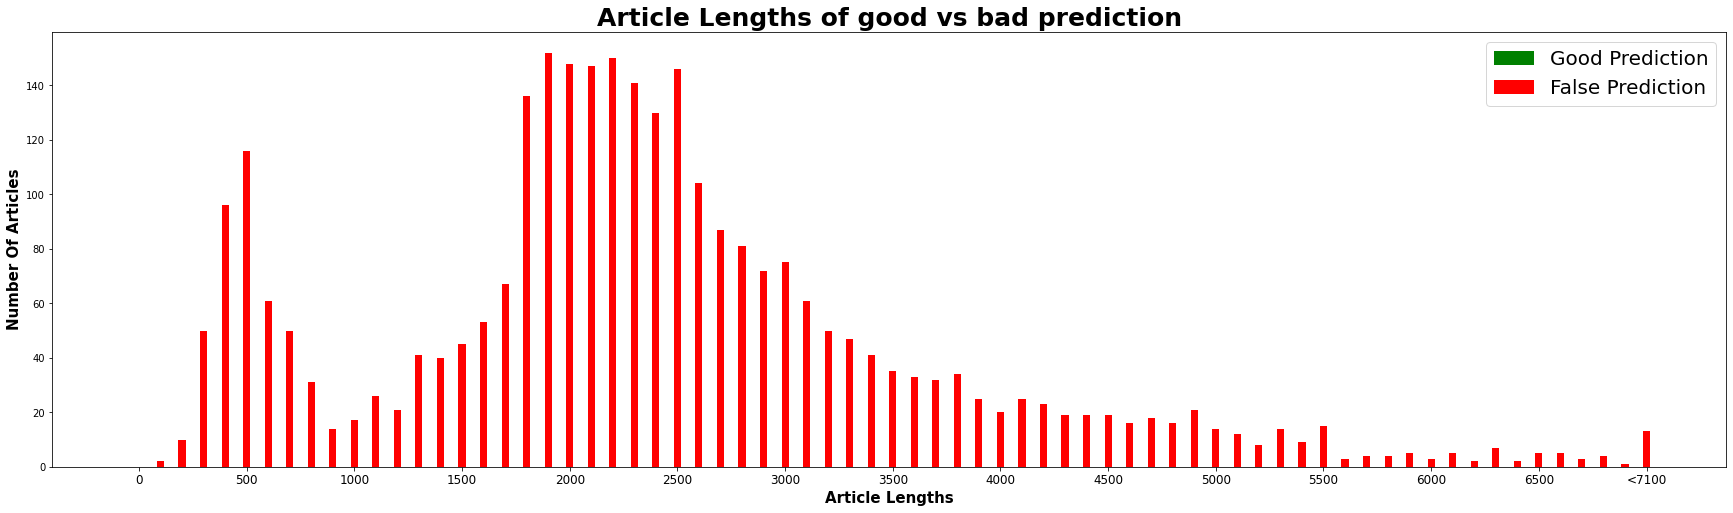

In [ ]:
plt.figure(figsize=(30, 8))
barWidth = 0.33
h1 = [i for i in range(len(good_pred_len_list))]
h2 = [i + barWidth for i in h1]
group = [str(i*500) for i in range((len(good_pred_len_list))//5)] + ["<"+str(len(good_pred_len_list)*100)]

plt.title("Article Lengths of good vs bad prediction", fontweight ='bold', fontsize = 25)
plt.bar(h1, good_pred_len_list, color = "green", label ='Good Prediction', width = barWidth)
plt.bar(h2, false_pred_len_list, color = "red", label ='False Prediction', width = barWidth)
plt.xlabel('Article Lengths', fontweight ='bold', fontsize = 15)
plt.ylabel('Number Of Articles', fontweight ='bold', fontsize = 15)
plt.xticks([i*5+barWidth for i in range(len(group))], group, fontsize = 12)

plt.legend(fontsize = 20)
plt.show()

## Article prediction

Once we have trained our model and assessed its performance, we want to evaluate its ability to correctly classify a single article. However, we previously noted that we do not expect our model to accurately classify single articles due to its size. Nonetheless, we are interested in exploring any potential practical applications of our model.

In this section we test on some more articles that we ask ChatGPT to write

In [ ]:
def Predict_Article (model, title, article):

    df_pred = pd.DataFrame(data={'title':[title], 'text':[article]})
    df_pred['text'] = df_pred['text'].apply(wordopt)
    df_pred['title'] = df_pred['title'].apply(wordopt)
    vec_article = pre_proccess_data(df_pred, pad_text_size=pad_text_size,
                              pad_title_size=pad_title_size, vectorize_method="GloVe")


    xs1 = np.array([(element[pad_title_size:]) for element in vec_article]) #articles
    xs2 = np.array([(element[:pad_title_size]) for element in vec_article]) #title

    #convert to torch comptible type
    xs1 = torch.from_numpy(xs1).long().to(device)
    xs2 = torch.from_numpy(xs2).long().to(device)

    zs = model(xs1, xs2)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    if torch.cuda.is_available():
        pred = pred.detach().cpu().numpy()

    return pred

In [ ]:
#ChatGPT order to write: "write article of 1000 words about real news on the politics of 2017 in usa"


Test_Fake_Title = "politics article"

Test_Fake_Article = """ The year 2017 was a tumultuous one in US politics. With the inauguration of a new president, the country saw a wave of controversy, protests, and policy changes. Here are some of the most significant events that shaped the politics of 2017.

Inauguration of President Donald Trump

On January 20, 2017, Donald Trump was inaugurated as the 45th President of the United States. His inauguration was marked by controversy and protests, with many Americans unhappy with the outcome of the 2016 presidential election. Trump's inauguration speech focused on his populist message, promising to put "America first" and restore jobs and wealth to the country. His presidency would be marked by many divisive policies and actions, such as his controversial travel ban on several Muslim-majority countries, his efforts to repeal the Affordable Care Act, and his hardline stance on immigration.

Russia investigation and the firing of FBI Director James Comey

In May 2017, President Trump fired FBI Director James Comey, who was leading an investigation into Russian interference in the 2016 presidential election. This move sparked controversy and calls for a special prosecutor to investigate the Trump campaign's ties to Russia. In May, the Department of Justice appointed former FBI Director Robert Mueller as special counsel to oversee the investigation. Over the course of the year, the investigation would lead to several indictments of Trump associates and the guilty pleas of former National Security Advisor Michael Flynn and former Trump campaign adviser George Papadopoulos.

Healthcare reform efforts and the passage of tax reform

One of President Trump's top priorities was the repeal and replacement of the Affordable Care Act, also known as Obamacare. In 2017, the Republican-controlled Congress made several attempts to pass a healthcare reform bill, but all efforts failed to gain enough support. In December 2017, Congress passed a major tax reform bill, which lowered the corporate tax rate and reduced taxes for many Americans. This bill was one of the few significant legislative achievements of the Trump administration in 2017.

North Korea tensions and the threat of nuclear war

Throughout 2017, tensions between the US and North Korea were high, with the North Korean government conducting several missile tests and threatening to use nuclear weapons against the US. President Trump responded with tough rhetoric, calling North Korean leader Kim Jong-un "Rocket Man" and threatening to unleash "fire and fury" on the country. The situation escalated in November, when North Korea tested a ballistic missile that could reach the US mainland. The year ended with the UN imposing new sanctions on North Korea, in an attempt to force the country to abandon its nuclear weapons program.

Mass shootings and gun control debates

2017 was also marked by several high-profile mass shootings, including the Las Vegas shooting in October, which left 58 people dead and over 500 injured. These shootings sparked renewed debates about gun control in the US, with many calling for stricter laws to prevent such tragedies from happening. However, efforts to pass gun control legislation stalled in Congress, with many Republicans opposing any new gun laws.

Protests and social movements

2017 was also a year of social movements and protests, with many Americans taking to the streets to voice their opposition to the Trump administration's policies. The Women's March, which took place the day after Trump's inauguration, was one of the largest protests in US history, with millions of people marching in cities across the country. The year also saw the rise of the #MeToo movement, which exposed widespread sexual harassment and assault in Hollywood and other industries.

In conclusion, the politics of 2017 in the US were marked by controversy, divisiveness, and unprecedented events. The Trump administration's policies and actions sparked protests and opposition, while investigations into Russian interference in the 2016 election and the firing of FBI Director James Comey
"""

actual = "True" # "True" or "Fake"
Article_Pred = Predict_Article(BestModel, Test_Fake_Title, Test_Fake_Article)

pred = "True" if Article_Pred==1 else "Fake"
good_pred = "Good" if pred == actual else "Bad"
print("The Model predict {} article".format(pred))
print("This is a {} prediction!".format(good_pred))

The Model predict True article
This is a Good prediction!


In [ ]:
#ChatGPT order to write: "write an 200 word article on the wining of Hapoel football team in the Derbi against Maccabi team"

Test_Fake_Title = "tel aviv derby"

Test_Fake_Article = """ In a thrilling match between two of Israel's top football teams, Hapoel emerged victorious over Maccabi in the latest Derbi. With both teams putting in their best efforts, the match was a tightly contested affair, with chances coming at both ends of the pitch.

The first half saw Hapoel taking the lead with a well-placed goal from their star striker. Maccabi tried to get back in the game, but Hapoel's defense held strong, keeping them at bay.

In the second half, Maccabi came out with renewed energy and managed to equalize with a stunning free-kick. However, Hapoel refused to give up and continued to push forward, with their midfielders dominating possession and creating chances.

With only a few minutes left on the clock, Hapoel managed to score the winning goal, sending their fans into a frenzy and securing the three points. The team's victory was well-deserved, as they had played with passion, determination, and skill throughout the game.

The win will give Hapoel a boost in the league table, and they will look to build on their success in the upcoming matches. Maccabi, on the other hand, will need to regroup and come back stronger in their next game.
"""

actual = "Fake" # "True" or "Fake"
Article_Pred = Predict_Article(BestModel, Test_Fake_Title, Test_Fake_Article)

pred = "True" if Article_Pred==1 else "Fake"
good_pred = "Good" if pred == actual else "Bad"
print("The Model predict {} article".format(pred))
print("This is a {} prediction!".format(good_pred))

The Model predict Fake article
This is a Good prediction!


As we can see out model stiil don't have good understending of israeli sports. :

## Conclusions

Utilizing neural networks for fake news detection is just one of the many examples of the potential and possibilities offered by machine learning. Ultimately, we were able to construct a network using basic neural network units that accurately identified fake and true news. Contemplating what large companies and future researchers may achieve in this field can be truly awe-inspiring.

Nevertheless, we encountered several significant challenges that can teach us about the general difficulties involved in building neural network models:
<br><br>
**Complexity-**One of the main challenges we faced was the complexity of the model and the amount of memory resources required to train it. Text analysis is a common problem in machine learning, and as such, we had access to many different options for our model layers.

However, we aimed to build a network that would yield both good results and low processing time. We discovered that the complexity of the model necessitated a reduction in input dimensions, which, as previously noted, affected the model's performance.
<br> We assume that large companies such as Facebook and Google have the resources to overcome these types of issues, but for us, the network size is crucial for save time and get good performances.

**Hyper parameters-**	We tried different combinations of hyper parameters for solving different problem we faced during the model’s training. The procedure of hyperparameters and data cleaning can always be challange in built NN model.



## Appendices

###Appendix A - CharNGram

Unlike the GloVe algorithm, the CharNGram is untended only for the embedding layer.<br> The option of vectorized words using CharNGram is exist, but yields very poor results:

In [ ]:
CharNGram_model = train_model(model_name = model,
                        df_true = df_train_val_true, df_fake = df_train_val_fake, train_part=0.8,
                        pad_text_size=pad_text_size, pad_title_size=pad_title_size,
                        kernel_size=3, optimizer = 'Adam',
                        embedding_dim=100, Embedding_method='CharNGram', Vectorize_method='CharNGram',
                        epochs=7, batch_size=128,
                        lr=0.0005, weight_decay=0,
                        checkpoint_bool=False)

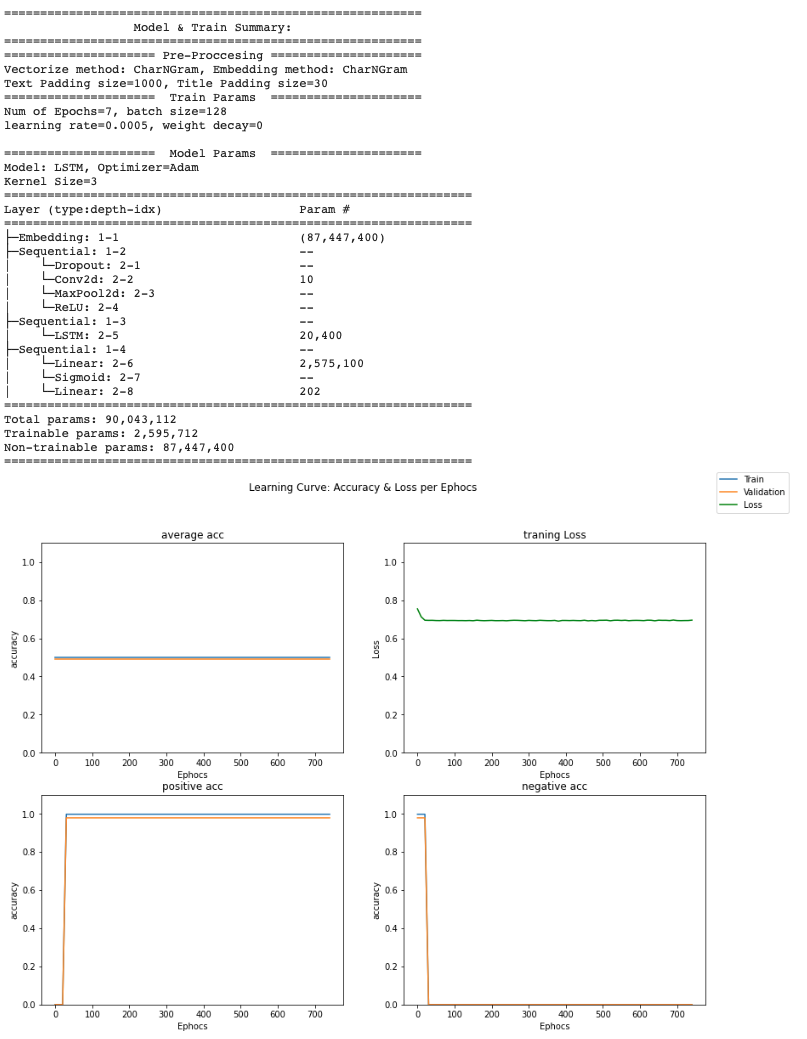

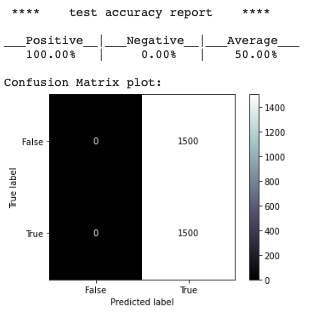

## Bibliography

We used the following sources for compare our model's performance and learn in details about the subject:   

*   https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9537782
*   https://www.kaggle.com/code/barkhaverma/fake-news-detection#Spiliting-and-Training

*   https://www.kaggle.com/code/khanrahim/fake-news-classification-easiest-99-accuracy
*   https://www.kaggle.com/code/therealsampat/fake-news-detection

*   https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7
*   https://arxiv.org/ftp/arxiv/papers/2102/2102.04458.pdf





